In [27]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation
from sklearn.decomposition import PCA, IncrementalPCA, KernelPCA
from sklearn.datasets import fetch_openml, make_swiss_roll
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.random_projection import (
    johnson_lindenstrauss_min_dim,
    GaussianRandomProjection,
)
from sklearn.manifold import LocallyLinearEmbedding, MDS, Isomap, TSNE

In [2]:
m = 60
X = np.zeros((m, 3))  # initialize 3D dataset
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # uneven distribution
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # oval
X += 0.28 * np.random.randn(m, 3)  # add more noise
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # shift a bit

In [3]:
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

In [4]:
# this projects the training set onto the plane defined by the first two principal components
W2 = Vt[:2].T
X2D = X_centered @ W2

In [5]:
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)
# after fitting the PCA transformer to the dataset, you can access the principal components using the components_ variable which holds transpoe of Wd contains 1 row for each of the first d principal components, where d is the number of dimensions (in this example, d=2)

In [6]:
# the explained_variance_ratio_ variable returns the ratio of variance that lies along each principal component
# this indicated the proportion of the dataset's variance that lies along the axis of each principal component
pca.explained_variance_ratio_
# output tells us that 76% of the dataset's variance lies along the first PC and 15% lies along the second PC leaving less than 9% for the third PC

array([0.7578477 , 0.15186921])

In [7]:
# choose the number of dimensions that add up to a sufficiently large portion of the variance (e.g., 95%)
# unless for data viz. in this case we can reduce the dimensionality down to 2D or 3D
mnist = fetch_openml("mnist_784", as_frame=False, parser="auto")
X_train, y_train = mnist.data[:60000], mnist.target[:60000]
X_test, y_test = mnist.data[60000:], mnist.target[60000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1  # 154

In [8]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)
pca.n_components_  # 154

154

In [9]:
# the following creates a 2step pipeline first reducing dimensionality using then random forest classifier then randomized search cv to find the best hyperparameters for both the dimensionality reduction and the classifier
clf = make_pipeline(PCA(random_state=42), RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500),
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3, random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       492, 493, 494, 495, 496, 497, 498, 499])},
                   random_state=42)

In [10]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': 465, 'pca__n_components': 23}


In [11]:
clf = make_pipeline(PCA(random_state=42), SGDClassifier())
param_grid = {"pca__n_components": np.arange(10, 80)}
grid_search = GridSearchCV(clf, param_grid, cv=3, verbose=1)
grid_search.fit(X_train[:1000], y_train[:1000])

Fitting 3 folds for each of 70 candidates, totalling 210 fits


GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                       ('sgdclassifier', SGDClassifier())]),
             param_grid={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79])},
             verbose=1)

In [12]:
grid_search.best_params_

{'pca__n_components': 60}

In [13]:
pca = PCA(0.95)
X_reduced = pca.fit_transform(X_train, y_train)

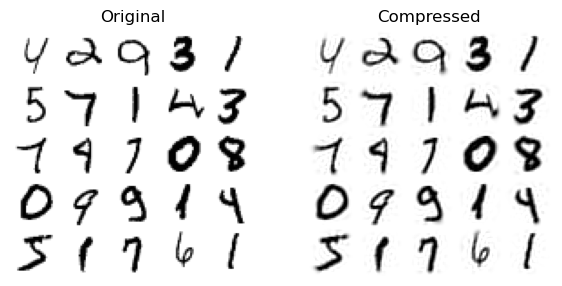

In [14]:
X_recovered = pca.inverse_transform(X_reduced)
plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(
                X[row * 5 + col].reshape(28, 28),
                cmap="binary",
                vmin=0,
                vmax=255,
                extent=(row, row + 1, col, col + 1),
            )
            plt.axis([0, 5, 0, 5])
            plt.axis("off")

In [15]:
# randomized PCA scikit learn uses a stochastic algorithm that quickly finds an approximation of the first d principal components
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)
# if you want sklearn to use the fill svd for a more precise results you can set the svd_solver hyperparameter to "full" but this will be very slow

In [16]:
# incremental PCA
# the previous algorithms need to fit the whole training set in memory in order to run
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

In [17]:
# we can also use numpy's memmap class which allows you to manipulate a large array stored in a binary file on disk as if it were entirely in memory
filename = "my_mnist.mmap"
X_mmap = np.memmap(filename, dtype="float32", mode="write", shape=X_train.shape)
X_mmap[:] = X_train
X_mmap.flush()

In [18]:
# we then load the memmap and use it to train the incremental PCA algorithm
X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)
batch_size = X_train.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)
# need to specify the data type and shape of the array when you load it if omitted it will return 1D array

IncrementalPCA(batch_size=600, n_components=154)

In [19]:
# Random Projection
# preserves distances very well to similar incances will likely remain close after projection
# if you have a dataset containing m = 5000 instances with n = 20000 features each and we dont want the squared distance to change by more than epsilon = 0.1 after projection
m, ε = 5_000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=ε)
d

7300

In [20]:
# extra code – show the equation computed by johnson_lindenstrauss_min_dim
d = int(4 * np.log(m) / (ε**2 / 2 - ε**3 / 3))
d

7300

In [21]:
# now we can generate a random matrix P of shape d,n where each element is drawn from a Gaussian distribution with mean 0 and variance 1/d
n = 20_000
np.random.seed(42)
P = np.random.randn(d, n) / np.sqrt(d)

X = np.random.randn(m, n)  # generates a fake dataset with m instances and n features
X_reduced = X @ P.T

In [22]:
# below does the same thing as above but using scikit learn
gaussian_rnd_proj = GaussianRandomProjection(eps=ε, random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X)

In [23]:
# scikit learn also provides a similar class for sparse matrices called SparseRandomProjection which uses less memory and is faster than GaussianRandomProjection when the dataset is very large and very sparse (i.e., when most features are zero most of the time)
# if you want to perform the inverse transformation you need to compute the pseudoinverse of the projection matrix using its pinv() function then multiply it by the reduced dataset
components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
X_recovered = X_reduced @ components_pinv.T

In [25]:
# local linear embedding
# first measures how each training instance linearly relates to its closest neighbors (c.n.) and then it looks for a low-dimensional representation of the training set where these local relationships are best preserved
X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)
# t is 1D numpy array containing the position of each instance along the lled axis of the swiss roll

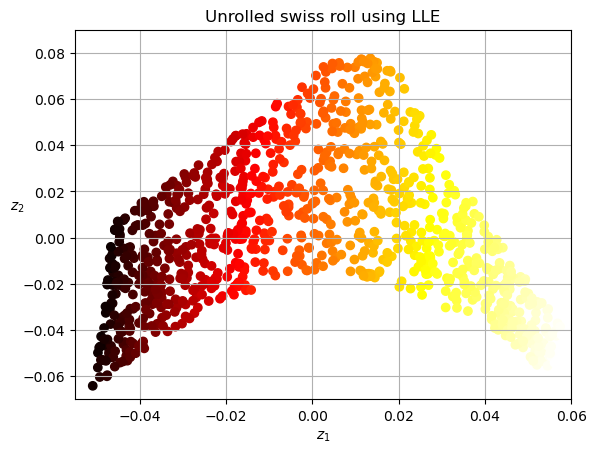

In [29]:
plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

plt.title("Unrolled swiss roll using LLE")
plt.show()

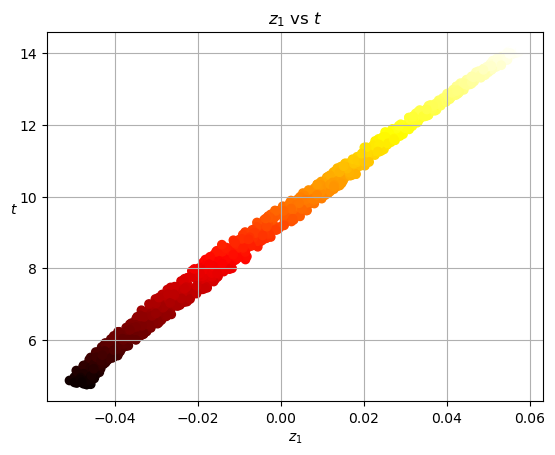

In [30]:
plt.title("$z_1$ vs $t$")
plt.scatter(X_unrolled[:, 0], t, c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$")
plt.ylabel("$t$", rotation=0)
plt.grid(True)
plt.show()

In [31]:
mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X_swiss)

isomap = Isomap(n_components=2)
X_reduced_isomap = isomap.fit_transform(X_swiss)

tsne = TSNE(n_components=2, init="random", learning_rate="auto", random_state=42)
X_reduced_tsne = tsne.fit_transform(X_swiss)

/Users/russell/miniconda3/envs/ML/lib/python3.11/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


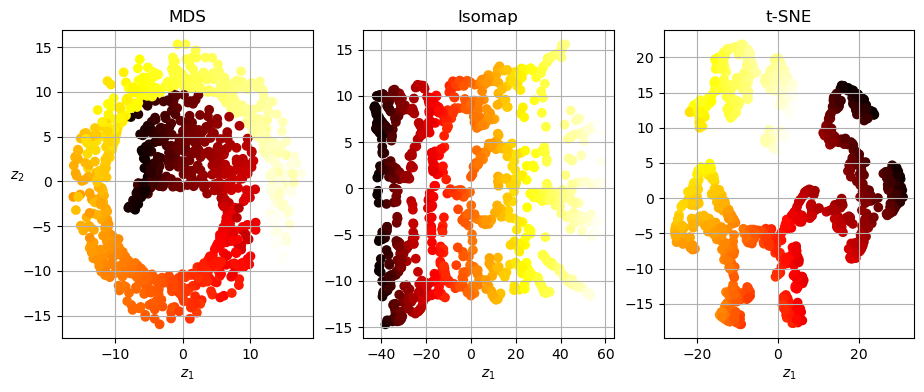

In [33]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11, 4))

for subplot, title, X_reduced in zip(
    (131, 132, 133), titles, (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)
):
    plt.subplot(subplot)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$")
    if subplot == 131:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid(True)

In [34]:
rbf_pca = KernelPCA(n_components=2, kernel="rbf", gamma=0.04, random_state=42)
X_reduced = rbf_pca.fit_transform(X_swiss)

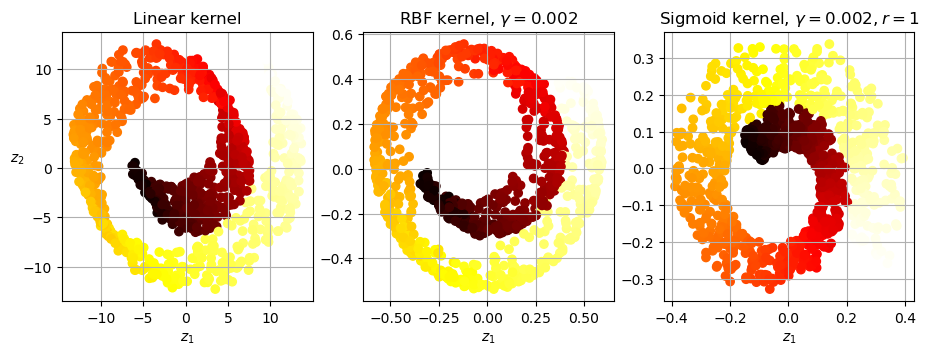

In [35]:
lin_pca = KernelPCA(kernel="linear")
rbf_pca = KernelPCA(kernel="rbf", gamma=0.002)
sig_pca = KernelPCA(kernel="sigmoid", gamma=0.002, coef0=1)

kernel_pcas = (
    (lin_pca, "Linear kernel"),
    (rbf_pca, rf"RBF kernel, $\gamma={rbf_pca.gamma}$"),
    (sig_pca, rf"Sigmoid kernel, $\gamma={sig_pca.gamma}, r={sig_pca.coef0}$"),
)

plt.figure(figsize=(11, 3.5))
for idx, (kpca, title) in enumerate(kernel_pcas):
    kpca.n_components = 2
    kpca.random_state = 42
    X_reduced = kpca.fit_transform(X_swiss)

    plt.subplot(1, 3, idx + 1)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
    plt.xlabel("$z_1$")
    if idx == 0:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid()

plt.show()